# Predicting New User Bookings on Airbnb

We seek to predict new user bookings on airbnb using data from 2009 to 2014. 

In [1]:
%matplotlib inline
from __future__ import division
import scipy as sp 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
pd.set_option("display.max_rows", 16) 
sns.set_style("darkgrid")
LARGE_FIGSIZE = (12, 8)
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
import xgboost
import itertools



# %cd airbnb-new-bookings
# %ls

In [2]:
#import data
filename = "train_users.csv"
# ?pd.read_table
all_data = pd.read_csv(filename, parse_dates=True, na_values = ["", ".", " ", "NA", "NaN", "-unknown-"])
all_data.drop('id',axis=1, inplace=True)
all_data.head()
# all_data.age.values

,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,2010-06-28,20090319043255,NaN,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,2010-09-14,20091208061105,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


## Lets explore the data!

In [3]:
#number of features
print "Looks like we have %s predictors" % all_data.shape[1]
print "And %s rows " % all_data.shape[0]
print
print "The object types in this dataset are: "
for col in all_data:
    print col, all_data[col].dtypes
print 
# all_data.columns.values.tolist()
# all_data.date_first_booking
print "Percentages of Missing Values"
nan_data = (all_data.isnull().sum() / all_data.shape[0]) * 100
nan_data[nan_data > 0]
# all_data.country_destination.isnull().sum()
# print nan_data

Looks like we have 15 predictors
And 213451 rows 

The object types in this dataset are: 
date_account_created object
timestamp_first_active int64
date_first_booking object
gender object
age float64
signup_method object
signup_flow int64
language object
affiliate_channel object
affiliate_provider object
first_affiliate_tracked object
signup_app object
first_device_type object
first_browser object
country_destination object

Percentages of Missing Values


date_first_booking         58.347349
gender                     44.829024
age                        41.222576
first_affiliate_tracked     2.841402
first_browser              12.773892
dtype: float64

## Data Visualizations

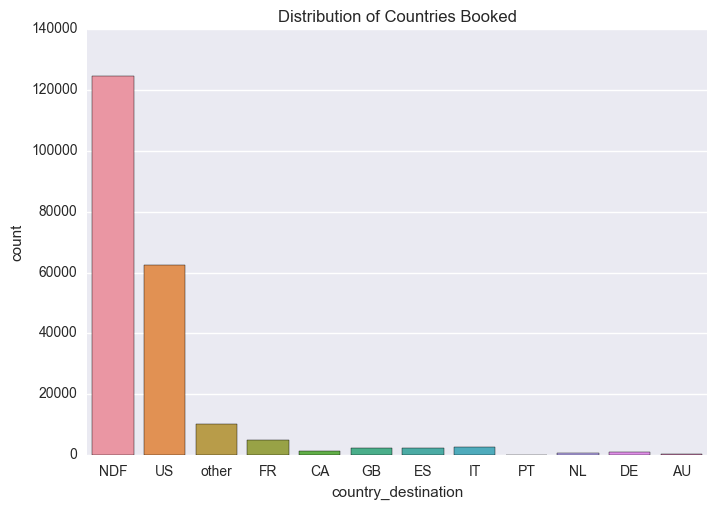

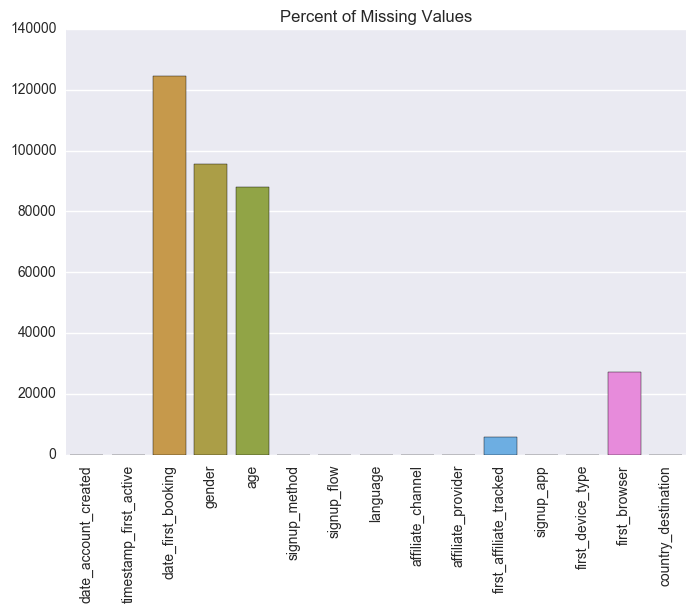

In [4]:
#distribution of countries
country_plot = sns.countplot(x='country_destination', data=all_data)
plt.title("Distribution of Countries Booked")
sns.plt.show()
#sns.barplot(x=all_data.country_destination.value_counts().index, y=all_data.country_destination.value_counts())

#number of NA
plot = sns.barplot(x=all_data.columns.values, y=all_data.isnull().sum())
plot.set_xticklabels(all_data.columns.values,rotation=30)
plt.title("Percent of Missing Values")
plt.xticks(rotation=90)

#uncomment out to see percentages of missing values
# total = float(len(all_data)) # one person per row 
# for p in plot.patches:
#     height = p.get_height()
#     per = height/total
#     if per > 0:
#         plot.text(p.get_x(), height+3, '%1.2f'%(per))
sns.plt.show()


## Data Pre-Processing

In [5]:
def remove_outliers(df, column, min_val, max_val):
    col_values = df[column].values
    df[column] = np.where(np.logical_or(col_values<=min_val, col_values>=max_val), np.NaN, col_values)
    return df


In [6]:
print("Fixing timestamps...")
all_data['date_account_created'] = pd.to_datetime(all_data['date_account_created'], format='%Y-%m-%d')
all_data['timestamp_first_active'] = pd.to_datetime(all_data['timestamp_first_active'], format='%Y%m%d%H%M%S')
all_data['date_account_created'].fillna(all_data.timestamp_first_active, inplace=True)

all_data.head()

Fixing timestamps...


,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,2010-06-28,2009-03-19 04:32:55,NaN,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,2011-05-25,2009-05-23 17:48:09,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,2010-09-14,2009-12-08 06:11:05,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [7]:
#remove NDF
print 'pre country: ', all_data.country_destination.shape

all_data = all_data[all_data.country_destination!='NDF']
print 'post country: ', all_data.country_destination.shape


pre country:  (213451,)
pre age:  (213451,)
post country:  (88908,)
post age:  (67139,)


/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()
/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()


Fixing age column...


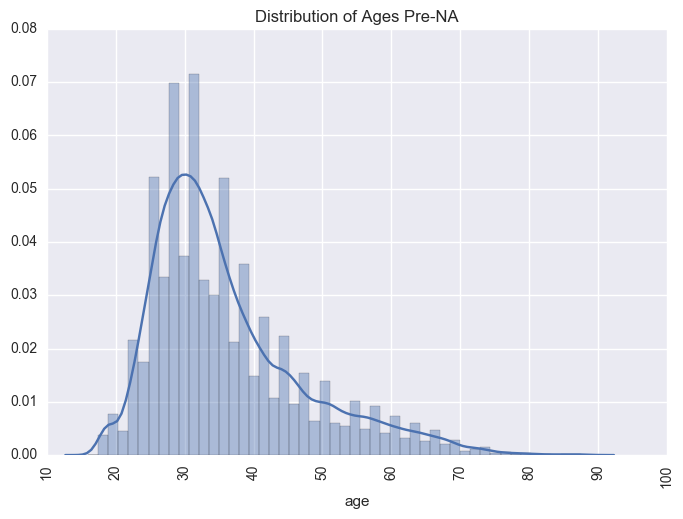

Any NA values in age? False
Imputing missing data with mean age of  36.0
Any NA values in age? False


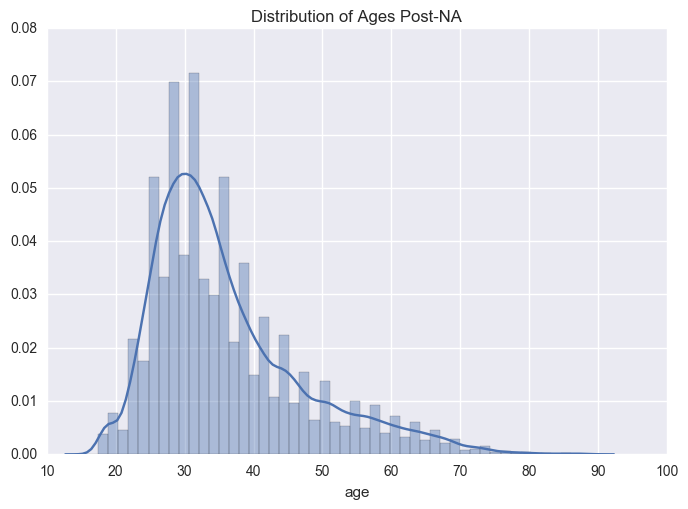

In [8]:
#observe age NA
print ("Fixing age column...")

pre_age_plot = sns.distplot(all_data.age.dropna(), bins =50 )
plt.title("Distribution of Ages Pre-NA")
plt.xticks(rotation=90)
sns.plt.show()

all_data = remove_outliers(df=all_data, column='age', min_val=18, max_val=90)
print "Any NA values in age?", all_data['age'].isnull().values.any()
mean_age = round(np.mean(all_data['age'].loc[all_data['age'].notnull()]))
print "Imputing missing data with mean age of ", mean_age
all_data['age'].fillna(mean_age, inplace=True)
all_data['age']= all_data['age'].astype(int)


print "Any NA values in age?", all_data['age'].isnull().values.any()
post_age_plot =sns.distplot(all_data.age, bins =50 )
plt.title("Distribution of Ages Post-NA")
sns.plt.show()


In [9]:
def fix_first_browser(df):
    list = ['Chrome', 'Safari', 'Firefox', 'IE', 'Mobile Safari', 'Chrome Mobile', 'Android Browser']
    for i, row in df.iterrows():
        if row.first_browser not in list:
           df.set_value(i,'first_browser', 'other')
    return df

Fixing date_first_booking...
Fixing first_affiliate_tracked...
Any NA values? False


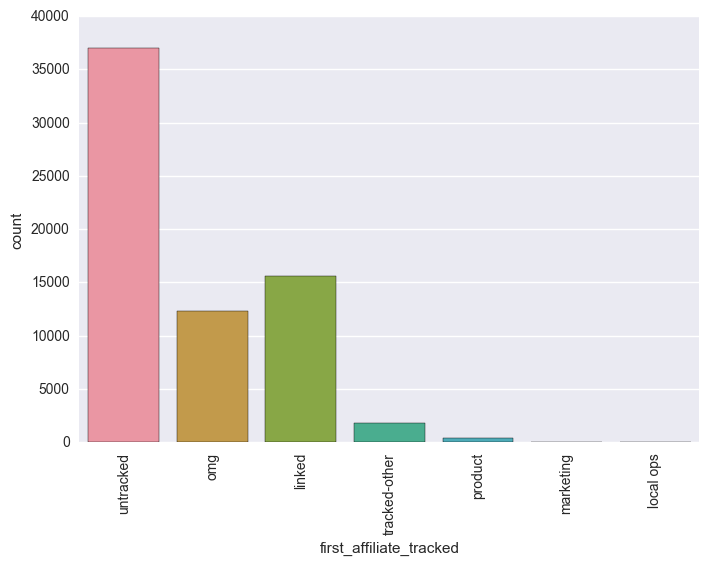

Fixing first_browser...


In [10]:
print("Fixing date_first_booking...")
all_data.drop('date_first_booking', axis=1, inplace=True)

print("Fixing first_affiliate_tracked...")
all_data['first_affiliate_tracked'].fillna(method = 'ffill', inplace = True)
print "Any NA values?", all_data['first_affiliate_tracked'].isnull().values.any()
affiliate_plot =sns.countplot(all_data['first_affiliate_tracked'])
plt.xticks(rotation=90)
sns.plt.show()
# print "Current NA count:", all_data['first_affiliate_tracked'].isnull().sum()
# all_data = all_data[all_data.first_affiliate_tracked.notnull()]
# print "New NA count:", all_data['first_affiliate_tracked'].isnull().sum()

print ("Fixing first_browser...")
all_data = fix_first_browser(all_data)

# print all_data.head()
# all_data['first_browser'].fillna(method = 'ffill', inplace = True)


In [11]:
#fix datatypes
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'country_destination',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method',
    'signup_flow'
]

print("Converting objects to categories...")
for categorical_feature in categorical_features:
   all_data[categorical_feature] = all_data[categorical_feature].astype('category')


Converting objects to categories...


Adding new date fields...
Any NA values? False


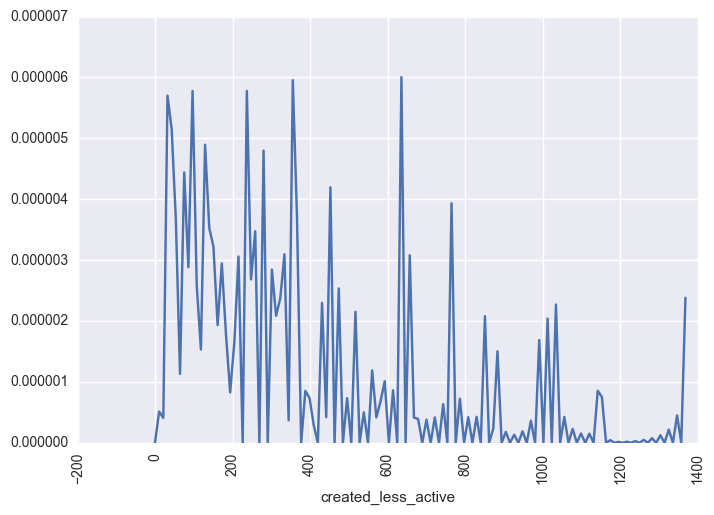

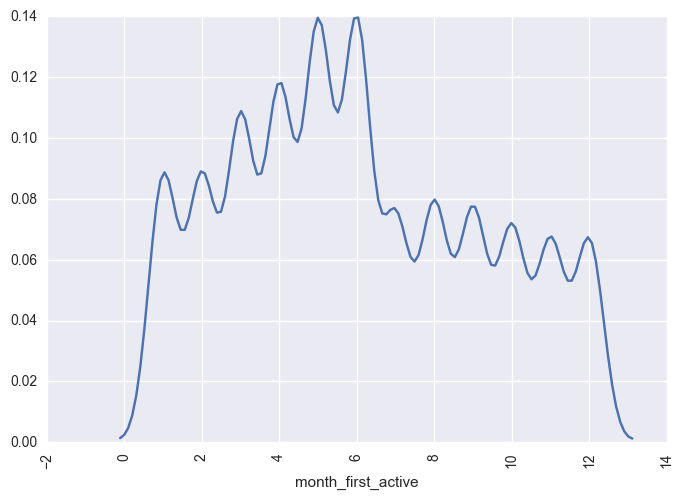

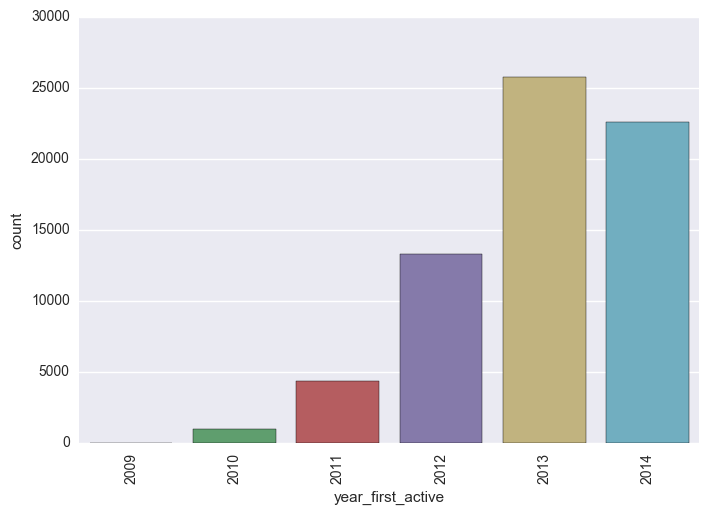

In [12]:
#extracting date values 
# Add new date related fields
print("Adding new date fields...")
all_data['day_account_created'] = all_data['date_account_created'].dt.weekday
all_data['month_account_created'] = all_data['date_account_created'].dt.month
all_data['quarter_account_created'] = all_data['date_account_created'].dt.quarter
all_data['year_account_created'] = all_data['date_account_created'].dt.year
all_data['hour_first_active'] = all_data['timestamp_first_active'].dt.hour
all_data['day_first_active'] = all_data['timestamp_first_active'].dt.weekday
all_data['month_first_active'] = all_data['timestamp_first_active'].dt.month
all_data['quarter_first_active'] = all_data['timestamp_first_active'].dt.quarter
all_data['year_first_active'] = all_data['timestamp_first_active'].dt.year
all_data['created_less_active'] = (all_data['date_account_created'] - all_data['timestamp_first_active']).dt.days

# Drop unnecessary columns
columns_to_drop = ['date_account_created', 'timestamp_first_active']
for column in columns_to_drop:
    if column in all_data.columns:
        all_data.drop(column, axis=1, inplace=True)

# all_data.head()
print "Any NA values?", all_data['first_affiliate_tracked'].isnull().values.any()

created_less_plot =sns.distplot(all_data['created_less_active'], hist = False)
plt.xticks(rotation=90)
sns.plt.show()

created_less_plot =sns.distplot(all_data['month_first_active'], hist = False)
plt.xticks(rotation=90)
sns.plt.show()

created_less_plot =sns.countplot(all_data['year_first_active'])
plt.xticks(rotation=90)
sns.plt.show()

# sns.regplot(all_data['created_less_active'],all_data['year_first_active'])
# plt.xticks(rotation=90)
# sns.plt.show()

Fixing gender...


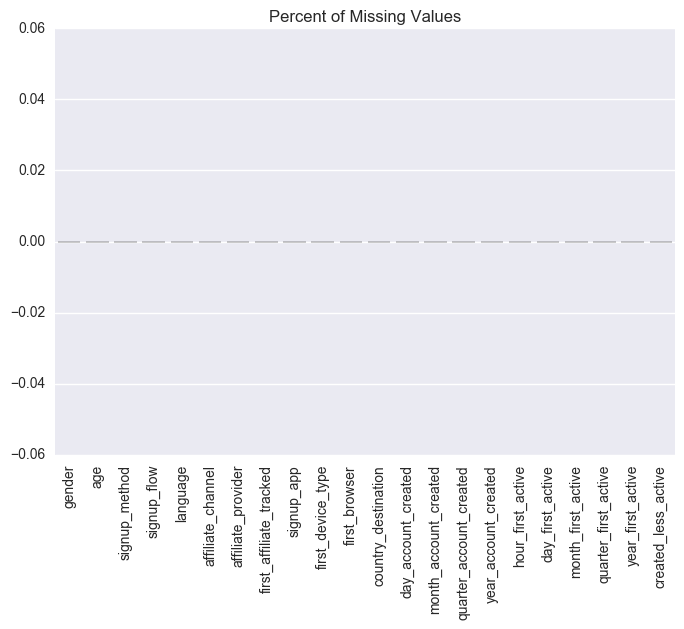

In [13]:
print("Fixing gender...")
pick_gender = ['FEMALE','MALE']
all_data['gender'].fillna(np.random.choice(pick_gender), inplace = True)

#updated missing values
plot = sns.barplot(x=all_data.columns.values, y=all_data.isnull().sum())
plot.set_xticklabels(all_data.columns.values,rotation=90)
plt.title("Percent of Missing Values")
sns.plt.show()

## Dummy Encode Categoricals

In [14]:
print "Generating dummy variables for categoricals..."
features = [
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method',
    'signup_flow'
]
dummies = pd.get_dummies(all_data[features])

for feature in all_data[features]:
    all_data.drop(feature,axis = 1, inplace = True)

# #test
# all_data.drop('country_destination',axis = 1, inplace = True)
frames = [all_data, dummies]
data_with_dummies = pd.concat(frames, axis = 1)
duplicate = data_with_dummies
data_with_dummies.head()

Generating dummy variables for categoricals...


,age,country_destination,day_account_created,month_account_created,quarter_account_created,year_account_created,hour_first_active,day_first_active,month_first_active,quarter_first_active,...,signup_flow_8,signup_flow_10,signup_flow_12,signup_flow_15,signup_flow_16,signup_flow_20,signup_flow_21,signup_flow_23,signup_flow_24,signup_flow_25
2,56,US,1,9,3,2010,23,1,6,2,...,0,0,0,0,0,0,0,0,0,0
3,42,other,0,12,4,2011,6,5,10,4,...,0,0,0,0,0,0,0,0,0,0
4,41,US,1,9,3,2010,6,1,12,4,...,0,0,0,0,0,0,0,0,0,0
6,46,US,5,1,1,2010,1,5,1,1,...,0,0,0,0,0,0,0,0,0,0
7,47,US,6,1,1,2010,19,6,1,1,...,0,0,0,0,0,0,0,0,0,0


# Compute Correlation after one-hot encoding
### Commented out due to computational extensiveness

In [15]:
# # calculate correlation of all numerical variables
# corr_data = data_with_dummies.drop('country_destination', axis = 1)
# corr_data.head()
# corr = np.corrcoef(corr_data)
# print corr


In [49]:
# data_with_dummies = duplicate

## Functions Used for Analysis

In [34]:
def get_metrics(model, x_test_target, x_test):
    #confusion matrix
    x_test_predict = model.predict(x_test)
    labels= x_test_target.value_counts().index.tolist()
    cm = confusion_matrix(x_test_target, x_test_predict)
#     print "Confusion Matrix: \n",cm
    
    cnf_matrix = cm
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=labels,
                          title='Confusion Matrix')
    plt.show()

    #mean accuracy
    acc = model.score(x_test, x_test_target)
    print "Mean accuracy: ",acc
    
    #precision/recall
    print "Precision: ", metrics.precision_score(x_test_target, x_test_predict, average = 'weighted')
    print "Recall: ", metrics.recall_score(x_test_target, x_test_predict, average = 'weighted')
    
    print classification_report(x_test_target, x_test_predict)

In [35]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
def get_importances(model, x_test):
    #get importances > 0
    print "Feature importance ranking: \n"
    feature_imp = model.feature_importances_

    # for x in range (0, len(feature_imp)):
    #     print x_test.columns[x],":", feature_imp[x]

    #consider varying this threshold
    feature_greater = feature_imp[feature_imp>0.005]
    feature_less = feature_imp[feature_imp<=0.005]

    indices = np.argsort(feature_imp)
    print "original size", feature_imp.shape
    print "size after reducing features", feature_greater.shape
    print "max feature importance", np.max(feature_imp)
    print "min feature importance", np.min(feature_imp)
    feature_greater_indices = np.argsort(feature_greater)

    plt.figure(2)
    plt.title('Feature Importances')
    plt.barh(range(len(feature_greater_indices)), feature_greater[feature_greater_indices], color='b')
    plt.yticks(range(len(feature_greater_indices)), x_test[feature_greater_indices])
    plt.xlabel('Relative Importance')

    plt.figure(3)
    plt.title('Feature Importance Distribution')
    plt.hist(feature_imp)
    plt.xlabel('Relative Importance')


In [21]:
def histogram_plot( model, x_test_target, x_test ):
    print "Test - Histogram of predicted probabilities:" 
    x_test_predict = model.predict_proba(x_test)[:, 1]
    plt.figure(1)
    plt.hist(x_test_predict, bins=8)
    plt.xlim(0, 1)
    plt.title('Histogram of predicted probabilities')
    plt.xlabel('Predicted probability country destination')
    plt.ylabel('Frequency')
    plt.show()
    plt.close() 

In [20]:
def clean_importances(model, x_test, data_with_dummies):
    print "Feature importance ranking: \n"
    feature_imp = model.feature_importances_
    
    #consider varying this threshold
    feature_greater = feature_imp[feature_imp>0.005]
    feature_less = feature_imp[feature_imp<=0.005]
    feature_greater_indices = np.argsort(feature_greater)
    
    features = x_test.columns[feature_greater_indices].tolist()
    frames = [data_with_dummies['country_destination'], data_with_dummies[features]]
    data_with_dummies = pd.concat(frames, axis = 1)
    print data_with_dummies.shape
    return data_with_dummies
    
    


In [22]:
def cross_val_trees(x_train, x_train_target):
    n_estimators = 100
    forest = RandomForestClassifier(warm_start=True, oob_score=True)
    errors = {}
    for i in range(1, n_estimators + 1,10):
        forest.set_params(n_estimators=i)
        forest.fit(x_train, x_train_target)
        errors[i] = 1 - forest.oob_score_
    max_err = max(errors.values())

    for key, value in errors.iteritems():
        if value == max_err:
            marker = key
    print marker

    #plot the trees and error
    plt.figure(figsize=(20,5))
    error_plot = plt.subplot(131)
    plt.plot(range(1, n_estimators + 1,10),
             errors.values(), 
             marker='o', 
             linestyle='--',
             c='black')
    error_plot.set_title("OOB Error vs. Number of Trees")
    error_plot.set_xlabel("Number of Trees")
    error_plot.set_ylabel("OOB Error")


In [23]:
def up_sample(df, under_rep_name, over_rep_name):
    
    # get the total count of underrepresented group
    sample_size = len(df[df.country_destination == over_rep_name])
#     print "Sample size: ",sample_size
    
    under_rep_class_indices = df[df.country_destination == under_rep_name].index
    under_rep_class = df.loc[under_rep_class_indices]
    
    over_rep_class_indices = df[df.country_destination == over_rep_name].index
    over_rep_class = df.loc[over_rep_class_indices]
    
    # set random state
    rnd = np.random.RandomState(0)
    
    # use the underrepresented group count to randomly sample from overrepresented group
    random_indices = rnd.choice(under_rep_class_indices, sample_size, replace=True) 
    
    #increase the number of under_rep observations to that of the over_rep observations
    under_rep_class = df.loc[random_indices]
    
    return under_rep_class


### Split Data

In [50]:
train = data_with_dummies.drop('country_destination', axis = 1)
test = data_with_dummies['country_destination']
x_train, x_test, x_train_target, x_test_target = train_test_split(train,test, test_size=0.3, random_state=0)

print "X train size is", x_train.shape
print "X train_target size is", x_train_target.shape
print "X test size is", x_test.shape
print "X test_target size is", x_test_target.shape

x_test.head()

# print data_with_dummies['country_destination'].ravel()

X train size is (46997, 108)
X train_target size is (46997,)
X test size is (20142, 108)
X test_target size is (20142,)


,age,day_account_created,month_account_created,quarter_account_created,year_account_created,hour_first_active,day_first_active,month_first_active,quarter_first_active,year_first_active,...,signup_flow_8,signup_flow_10,signup_flow_12,signup_flow_15,signup_flow_16,signup_flow_20,signup_flow_21,signup_flow_23,signup_flow_24,signup_flow_25
142835,26,4,1,1,2014,2,4,1,1,2014,...,0,0,0,0,0,0,0,0,0,0
8842,32,1,9,3,2011,12,1,9,3,2011,...,0,0,0,0,0,0,0,0,0,0
143283,22,5,1,1,2014,4,5,1,1,2014,...,0,0,1,0,0,0,0,0,0,0
1085,30,0,7,3,2010,4,0,7,3,2010,...,0,0,0,0,0,0,0,0,0,0
17387,58,1,2,1,2012,19,1,2,1,2012,...,0,0,0,0,0,0,0,0,0,0


### Cross Validation Trees
#### Let's find the best number of estimators for random forests

1


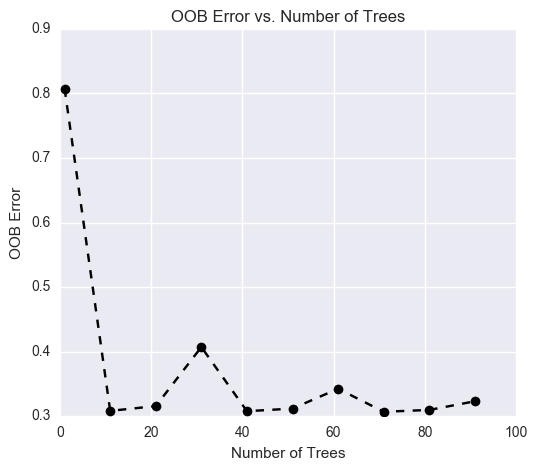

In [233]:
cross_val_trees(x_train, x_train_target)

## Random Forest Attempt 1
### 10 trees. With One-hot encoding.

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


Confusion Matrix: 
[[    0     0     0     0     4     1     0     0     0   110     4]
 [    1     1     0     1     3     2     1     0     0   306     9]
 [    2     0     0     2     6     3     0     2     1   236     7]
 [    0     2     1     3     6     3     7     1     0   451    14]
 [    1     6     1     6    17     9    13     5     1  1019    22]
 [    0     3     2     2    10     1     3     0     0   489     7]
 [    0     2     1     5    14     1     7     0     0   567    15]
 [    0     0     0     0     6     0     0     0     0   173     7]
 [    1     0     0     0     1     0     2     0     0    49     1]
 [   15    29    23    70   209    83    91    21     1 13360   351]
 [    1    13     4    13    36    14    15     8     2  2053    71]]
[[    0     0     0     0     4     1     0     0     0   110     4]
 [    1     1     0     1     3     2     1     0     0   306     9]
 [    2     0     0     2     6     3     0     2     1   236     7]
 [    0     2 

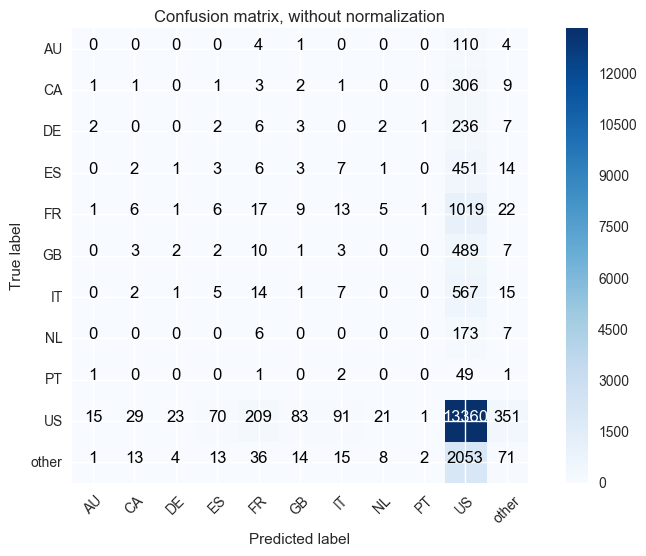

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


Mean accuracy:  0.668255386754
Precision:  0.523717372678
Recall:  0.668255386754
             precision    recall  f1-score   support

         AU       0.00      0.00      0.00       119
         CA       0.02      0.00      0.01       324
         DE       0.00      0.00      0.00       259
         ES       0.03      0.01      0.01       488
         FR       0.05      0.02      0.02      1100
         GB       0.01      0.00      0.00       517
         IT       0.05      0.01      0.02       612
         NL       0.00      0.00      0.00       186
         PT       0.00      0.00      0.00        54
         US       0.71      0.94      0.81     14253
      other       0.14      0.03      0.05      2230

avg / total       0.52      0.67      0.58     20142



In [30]:
rf1 = RandomForestClassifier(n_estimators=10, oob_score = True, verbose=1)
rf1.fit(x_train, x_train_target)
  
get_metrics(rf1, x_test_target, x_test)

# histogram_plot(rf1, x_test_target, x_test)

# get_importances(rf1, x_test)




## Random Forest Attempt 2
### 40 trees. With One-hot encoding.

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.5s finished


[[    0     0     0     1     3     1     0     0     0   111     3]
 [    0     0     0     2     2     0     0     0     0   317     3]
 [    1     1     0     1     2     0     0     0     0   251     3]
 [    0     1     0     2     2     0     4     0     0   474     5]
 [    0     1     1     5     6     4     0     3     0  1072     8]
 [    0     1     1     1     2     0     1     0     0   504     7]
 [    0     0     1     3     7     1     4     0     0   589     7]
 [    0     0     0     0     1     0     0     0     0   181     4]
 [    0     0     0     0     0     0     0     0     0    53     1]
 [   10    16    15    30    77    27    37     8     0 13842   191]
 [    0     6     2     5    10     4     3     1     0  2162    37]]


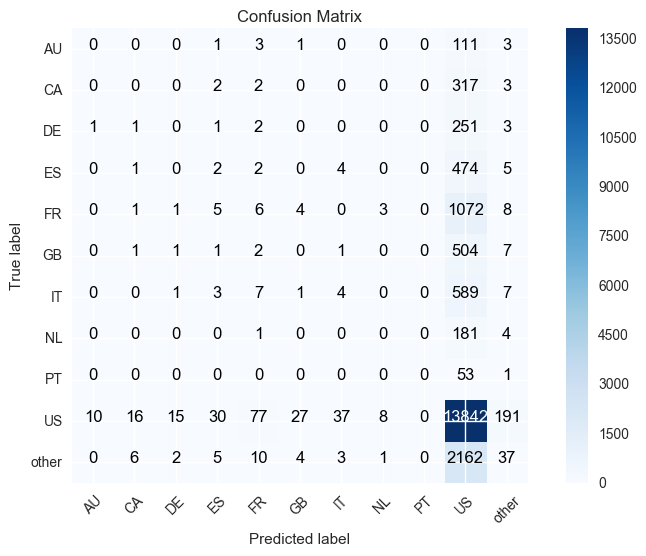

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.5s finished


Mean accuracy:  0.689653460431
Precision:  0.522470539554
Recall:  0.689653460431
             precision    recall  f1-score   support

         AU       0.00      0.00      0.00       119
         CA       0.00      0.00      0.00       324
         DE       0.00      0.00      0.00       259
         ES       0.04      0.00      0.01       488
         FR       0.05      0.01      0.01      1100
         GB       0.00      0.00      0.00       517
         IT       0.08      0.01      0.01       612
         NL       0.00      0.00      0.00       186
         PT       0.00      0.00      0.00        54
         US       0.71      0.97      0.82     14253
      other       0.14      0.02      0.03      2230

avg / total       0.52      0.69      0.58     20142

Test - Histogram of predicted probabilities:


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.5s finished


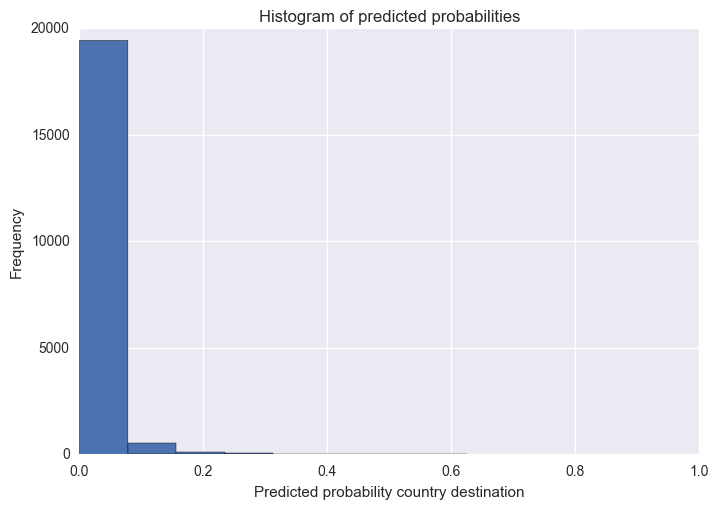


Feature importance ranking: 

original size (108,)
size after reducing features (31,)
max feature importance 0.189957503005
min feature importance 0.0


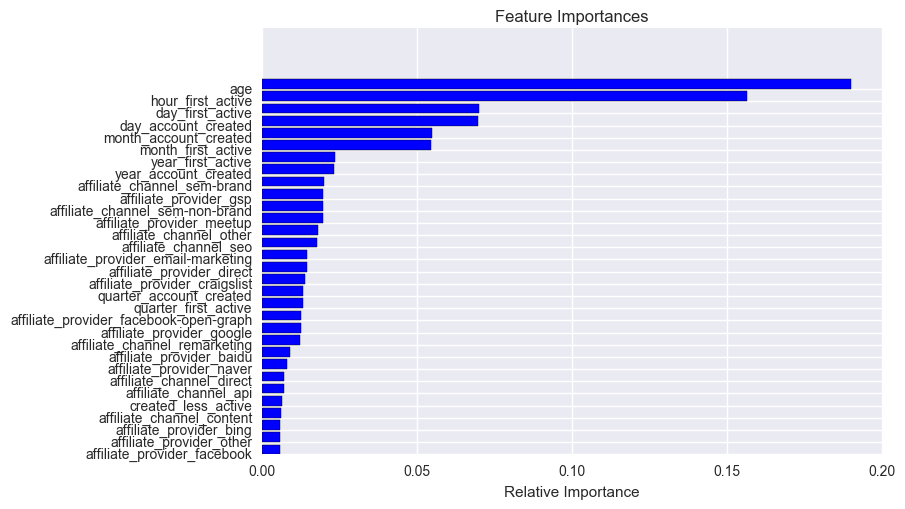

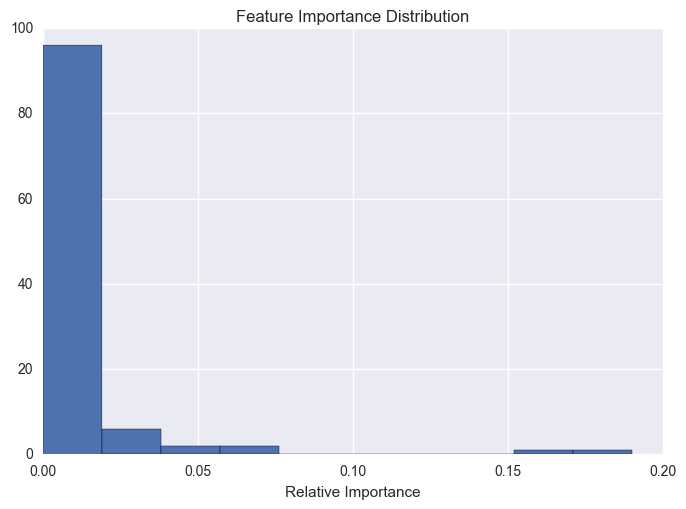

In [51]:
rf1 = RandomForestClassifier(n_estimators=40, oob_score = True, verbose=1)
rf1.fit(x_train, x_train_target)

get_metrics(rf1, x_test_target, x_test)

histogram_plot(rf1, x_test_target, x_test)
print 

get_importances(rf1, x_test)






## Random Forest Attempt 3
### 70 trees. With One-hot encoding.

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished


Confusion Matrix: 
[[    0     0     0     0     1     0     1     0     0   126     6]
 [    0     1     1     2     0     0     3     1     0   307     7]
 [    0     0     0     1     2     1     3     0     0   240     5]
 [    0     0     0     2     1     3     4     1     0   475     8]
 [    1     2     3     2     6     3     2     1     0  1101    25]
 [    0     0     1     4     7     5     1     0     0   478    10]
 [    1     2     2     3     4     1     1     0     0   580    15]
 [    0     0     0     2     1     1     0     0     0   176     6]
 [    0     0     0     1     0     1     0     0     0    40     4]
 [   10    31    18    55    96    43    47    13     6 13667   276]
 [    1     2     2     6     8     7    12     2     0  2099    45]]


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished


Mean accuracy:  0.681545106996
Precision:  0.519811107712
Recall:  0.681545106996
             precision    recall  f1-score   support

         AU       0.00      0.00      0.00       134
         CA       0.03      0.00      0.01       322
         DE       0.00      0.00      0.00       252
         ES       0.03      0.00      0.01       494
         FR       0.05      0.01      0.01      1146
         GB       0.08      0.01      0.02       506
         IT       0.01      0.00      0.00       609
         NL       0.00      0.00      0.00       186
         PT       0.00      0.00      0.00        46
         US       0.71      0.96      0.81     14262
      other       0.11      0.02      0.03      2184

avg / total       0.52      0.68      0.58     20141

Oob error:  0.319637423665
Test - Histogram of predicted probabilities:


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished


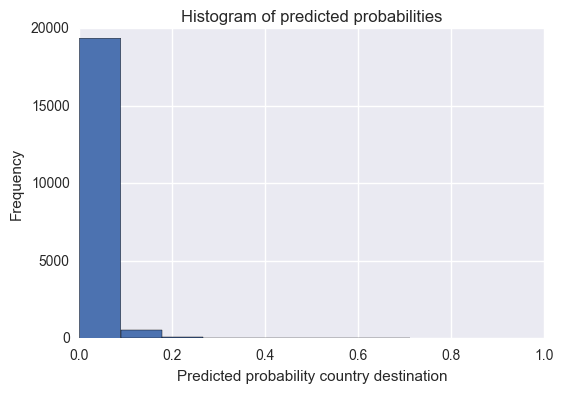


Feature importance ranking: 

first_affiliate_tracked_linked : 0.0171610465802
affiliate_provider_vast : 0.000684065145311
first_affiliate_tracked_untracked : 0.018734757242
affiliate_channel_content : 0.00194501197092
affiliate_channel_sem-brand : 0.00656225715353
affiliate_provider_yahoo : 0.000507268511694
first_browser_Firefox : 0.0182660874657
first_browser_Chrome Mobile : 0.00154414816045
affiliate_provider_email-marketing : 0.000125657703026
first_device_type_Other/Unknown : 0.00319819656799
affiliate_channel_seo : 0.00476832960047
affiliate_provider_bing : 0.00185862470008
affiliate_provider_facebook : 0.00188238023188
first_browser_Chrome : 0.0214314609599
first_browser_Mobile Safari : 0.0106003287459
first_browser_Android Browser : 0.000839893658048
first_device_type_Android Tablet : 0.00195211675349
first_device_type_Mac Desktop : 0.0266875374522
first_affiliate_tracked_omg : 0.0116674872432
affiliate_channel_api : 0.0017209431508
affiliate_provider_padmapper : 0.0002798892

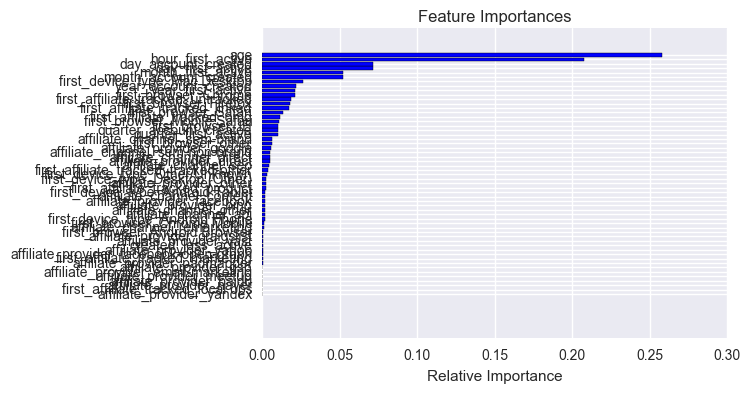

In [236]:
rf2 = RandomForestClassifier(n_estimators=70, oob_score=True, verbose=1)
rf2.fit(x_train, x_train_target)

get_metrics(rf2, x_test_target, x_test)


histogram_plot(rf2, x_test_target, x_test)
print 

get_importances(rf2, x_test)

## Random Forest Attempt 4
### 10 trees. With One-hot encoding. Balanced Classes.

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Confusion Matrix: 
[[    0     1     1     1     6     0     2     0     0   102     6]
 [    1     0     0     2     7     4     1     0     0   302     7]
 [    1     0     0     1     5     1     0     0     0   240    11]
 [    0     2     0     3     4     2     4     1     0   462    10]
 [    3     0     2     6    17     6     4     2     0  1041    19]
 [    0     2     2     3     6     1     3     0     0   489    11]
 [    1     2     1     3    11     4     6     1     0   568    15]
 [    0     1     0     1     4     2     1     0     0   169     8]
 [    0     0     0     0     0     1     0     0     0    50     3]
 [   16    34    31    70   185    78    74    12     2 13414   337]
 [    0     8     5     9    29    15     9     3     0  2082    70]]
[[    0     1     1     1     6     0     2     0     0   102     6]
 [    1     0     0     2     7     4     1     0     0   302     7]
 [    1     0     0     1     5     1     0     0     0   240    11]
 [    0     2 

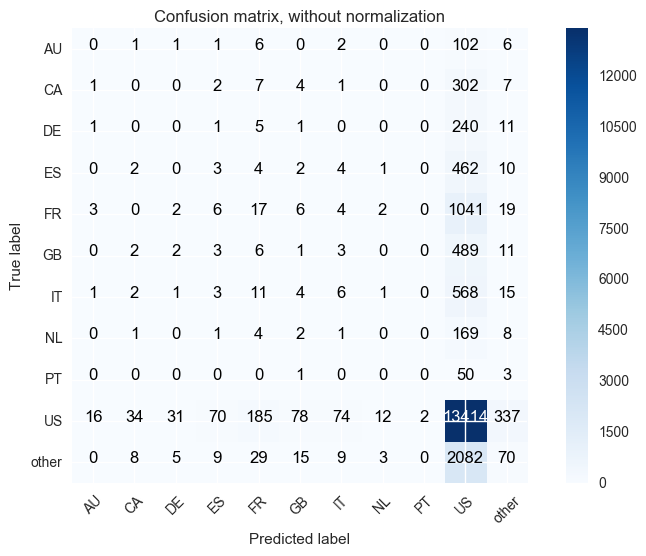

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Mean accuracy:  0.670787409393
Precision:  0.523416916722
Recall:  0.670787409393
             precision    recall  f1-score   support

         AU       0.00      0.00      0.00       119
         CA       0.00      0.00      0.00       324
         DE       0.00      0.00      0.00       259
         ES       0.03      0.01      0.01       488
         FR       0.06      0.02      0.02      1100
         GB       0.01      0.00      0.00       517
         IT       0.06      0.01      0.02       612
         NL       0.00      0.00      0.00       186
         PT       0.00      0.00      0.00        54
         US       0.71      0.94      0.81     14253
      other       0.14      0.03      0.05      2230

avg / total       0.52      0.67      0.58     20142

Oob error:  0.420728982701
Test - Histogram of predicted probabilities:


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


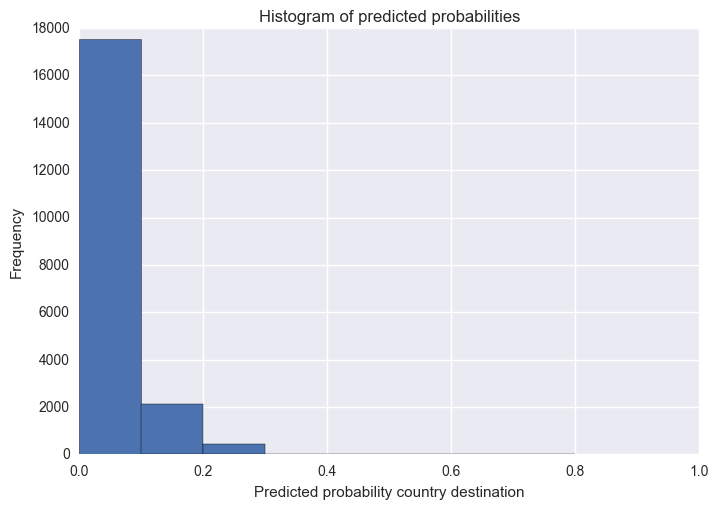


Feature importance ranking: 

original size (108,)
size after reducing features (34,)
max feature importance 0.146279202718
min feature importance 0.0


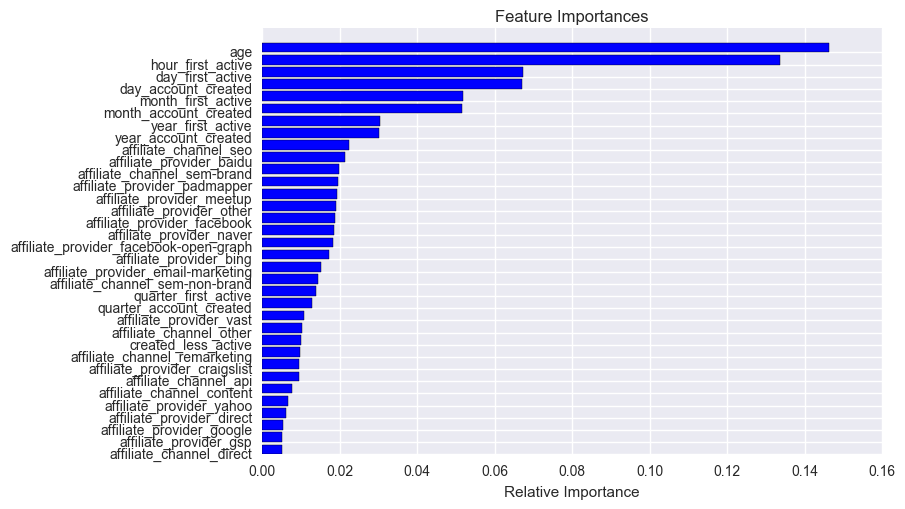

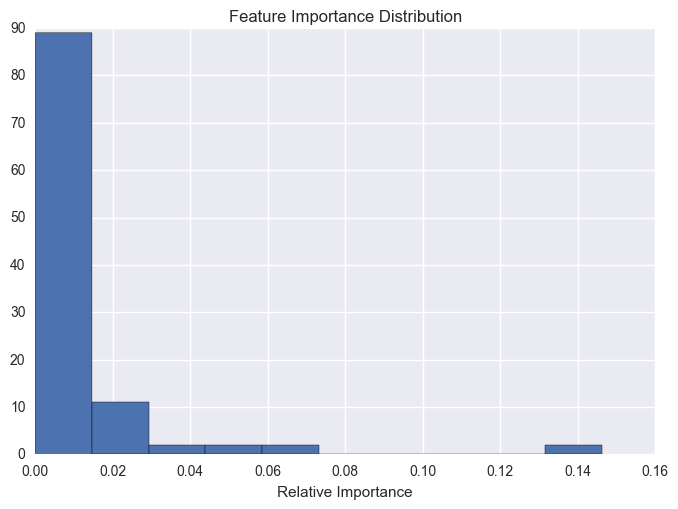

In [29]:
rf3 = RandomForestClassifier(n_estimators=10, verbose=1, oob_score = True, class_weight="balanced")
rf3.fit(x_train, x_train_target)

get_metrics(rf3, x_test_target, x_test)

#oob score
print "Oob error: ",1 - rf3.oob_score_

histogram_plot(rf3, x_test_target, x_test)
print 

get_importances(rf3, x_test)

## Grid Search Attempt 1
### Not balanced

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Confusion Matrix: 
[[    0     0     0     0     0     0     0     0     0   121     0]
 [    0     0     0     0     0     0     0     0     0   324     0]
 [    0     0     0     0     0     0     0     0     0   257     0]
 [    0     0     0     0     0     0     0     0     0   483     0]
 [    0     0     0     0     0     0     0     0     0  1105     0]
 [    0     0     0     0     0     0     0     0     0   517     0]
 [    0     0     0     0     0     0     0     0     0   581     0]
 [    0     0     0     0     0     0     0     0     0   167     0]
 [    0     0     0     0     0     0     0     0     0    44     0]
 [  

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

         AU       0.00      0.00      0.00       121
         CA       0.00      0.00      0.00       324
         DE       0.00      0.00      0.00       257
         ES       0.00      0.00      0.00       483
         FR       0.00      0.00      0.00      1105
         GB       0.00      0.00      0.00       517
         IT       0.00      0.00      0.00       581
         NL       0.00      0.00      0.00       167
         PT       0.00      0.00      0.00        44
         US       0.71      1.00      0.83     14367
      other       0.00      0.00      0.00      2175

avg / total       0.51      0.71      0.59     20141

Test - Histogram of predicted probabilities:


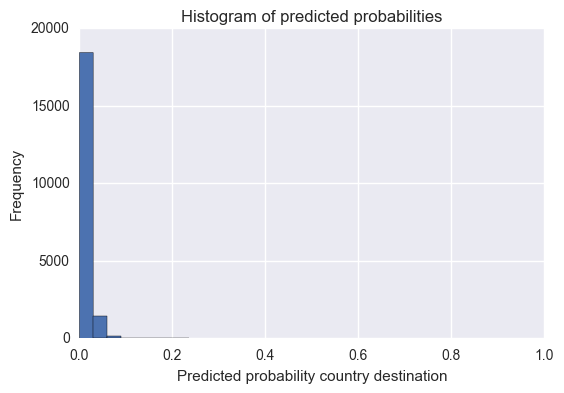


Feature importance ranking: 

age : 0.131171633031
day_account_created : 0.0598484441394
month_account_created : 0.053315491043
quarter_account_created : 0.0184920450225
year_account_created : 0.0288863423192
hour_first_active : 0.107242941349
day_first_active : 0.0603128172982
month_first_active : 0.0533197081759
quarter_first_active : 0.0178197809313
year_first_active : 0.0287307603489
created_less_active : 0.00185558816177
affiliate_channel_api : 0.00199015861894
affiliate_channel_content : 0.0041657836579
affiliate_channel_direct : 0.00898519523808
affiliate_channel_other : 0.00479264786562
affiliate_channel_remarketing : 0.00326456492463
affiliate_channel_sem-brand : 0.00962615523946
affiliate_channel_sem-non-brand : 0.00902871404797
affiliate_channel_seo : 0.00722514336158
affiliate_provider_baidu : 0.000149018853576
affiliate_provider_bing : 0.00416472726232
affiliate_provider_craigslist : 0.00267053041528
affiliate_provider_direct : 0.00876036789685
affiliate_provider_email-ma

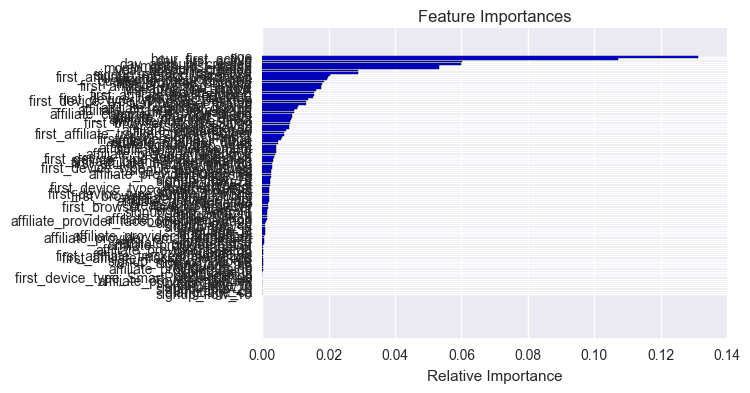

In [110]:
rf_grid = RandomForestClassifier()
param_grid = {
                 'n_estimators': [70,100],
                 'max_depth': [10, 20, 30],
                'min_samples_split':[2,4,6],
             }
grid_clf = GridSearchCV(rf_grid, param_grid)
labels = x_train_target['country_destination']
grid_clf.fit(x_train.values, labels)
print grid_clf.best_estimator_

get_metrics(grid_clf, x_test_target, x_test)

histogram_plot(grid_clf, x_test_target, x_test)
print 

get_importances(grid_clf.best_estimator_, x_test)

## Grid Search Attempt 2
### Balanced

In [235]:
rf_grid = RandomForestClassifier(class_weight="balanced")
param_grid = {
                 'n_estimators': [70,100],
                 'max_depth': [10, 20, 30],
                'min_samples_split':[2,4,6],
             }
grid_clf = GridSearchCV(rf_grid, param_grid)
labels = x_train_target['country_destination']
grid_clf.fit(x_train.values, labels)
print grid_clf.best_estimator_

get_metrics(grid_clf, x_test_target, x_test)

histogram_plot(grid_clf, x_test_target, x_test)
print 

get_importances(grid_clf.best_estimator_, x_test)

KeyboardInterrupt: 

## GridSearch attempt 3
### with only decision trees

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=6, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Confusion Matrix: 
[[    0     1     0     1     0     0     0     0     0   113     6]
 [    0     0     0     0     0     1     0     0     0   323     0]
 [    0     0     0     1     2     0     0     0     0   253     1]
 [    0     2     0     1     4     1     1     1     0   469     4]
 [    0     1     0     2     2     0     2     0     0  1087    11]
 [    0     0     0     2     1     1     1     0     0   508     4]
 [    0     0     0     5     0     0     1     1     0   570     4]
 [    1     0     0     1     0     0     0     0     0   163     2]
 [    0     0     0     1     0     0     0     0     0    41     2]
 [    4     4     0    12    44     5    12     1     1 14231    53]
 [    0     1     1

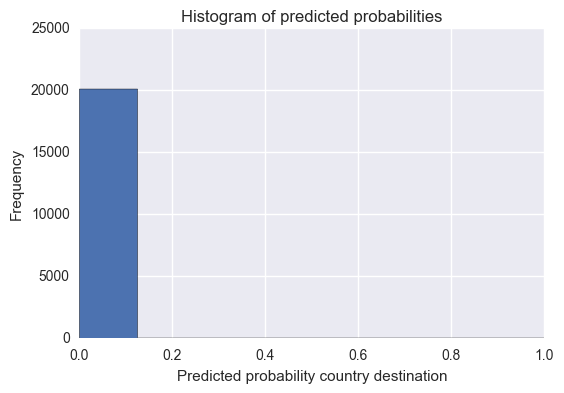


Feature importance ranking: 

signup_method_google : 0.0
affiliate_provider_google : 0.0
affiliate_provider_meetup : 0.0
affiliate_provider_naver : 0.0
first_affiliate_tracked_marketing : 0.0
signup_flow_5 : 0.0
first_affiliate_tracked_untracked : 0.0
first_browser_Chrome Mobile : 0.0
first_device_type_Android Tablet : 0.0
first_device_type_Desktop (Other) : 0.0
first_device_type_Other/Unknown : 0.0
first_device_type_SmartPhone (Other) : 0.0
language_no : 0.0
signup_flow_2 : 0.0
language_nl : 0.0
language_ca : 0.0
language_cs : 0.0
language_da : 0.0
language_is : 0.0
language_hu : 0.0
affiliate_provider_facebook-open-graph : 0.0
language_th : 0.0
affiliate_provider_yandex : 0.0
language_fi : 0.0
signup_flow_23 : 0.0
language_tr : 0.0
affiliate_provider_baidu : 0.0
signup_app_Android : 0.0
affiliate_channel_seo : 0.0
language_zh : 0.0
signup_flow_20 : 0.0
affiliate_channel_api : 0.0
signup_app_Moweb : 0.0
affiliate_provider_direct : 0.0
signup_flow_15 : 0.0
signup_app_iOS : 0.0
signup_

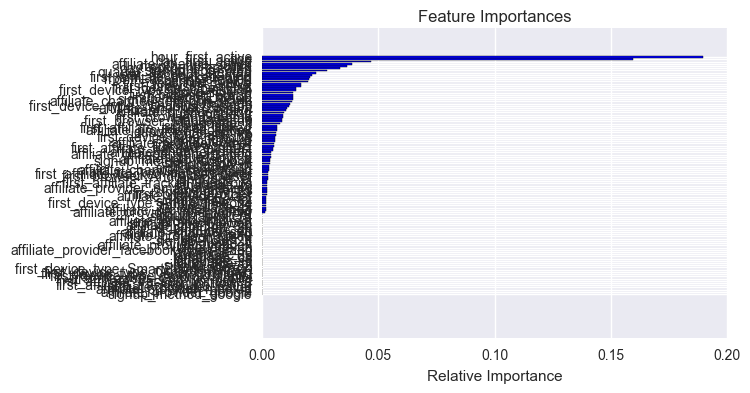

In [32]:
tree_grid_unbalanced = DecisionTreeClassifier()
param_grid = {
                 'criterion': ['gini', 'entropy'],
                 'max_depth': [10, 20, 30],
                'min_samples_split':[2,4,6],
             }
grid_clf_unbalanced = GridSearchCV(tree_grid_unbalanced, param_grid)
labels = x_train_target['country_destination']
grid_clf_unbalanced.fit(x_train.values, labels)
print grid_clf_unbalanced.best_estimator_

get_metrics(grid_clf_unbalanced, x_test_target, x_test)

histogram_plot(grid_clf_unbalanced, x_test_target, x_test)
print 

get_importances(grid_clf_unbalanced.best_estimator_, x_test)

tree.export_graphviz(grid_clf_unbalanced.best_estimator_, out_file='tree.dot')  

## GridSearch attempt 4
### with only decision trees and balanced classes

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Confusion Matrix: 
[[   2    6    2    7    5    4    1    2    0   89   11]
 [   3    7    5    7   16   15   12    2    2  215   40]
 [   1    6    5    6   15   12    7    4    1  162   23]
 [   7    8   10   26   41   20   18    7    1  329   77]
 [  10   25   22   42   79   32   41   19    7  711  128]
 [   3   11    6   17   43   14   25    2    1  346   48]
 [   1    4    9   29   53   24   16    5    1  397   72]
 [   1    3    3   10   12    6    6    3    1  116   22]
 [   0    1    0    1    8    1    1    0    0   28   13]
 [ 117  296  233  405  869  452  422  179   59 9568 1631]
 [  20   50   41   54  131   74   75   29    7 1426  285]]
Mean accuracy:  0.496747927114
Precision:  0.5247

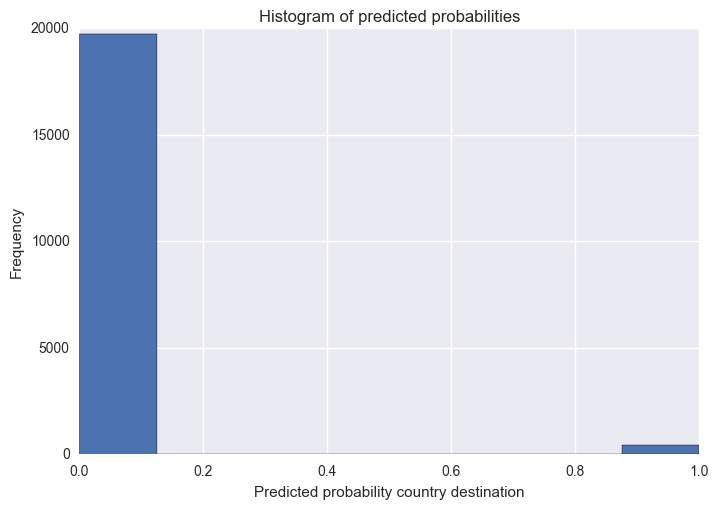


Feature importance ranking: 

original size (108,)
size after reducing features (34,)
max feature importance 0.203237040783
min feature importance 0.0


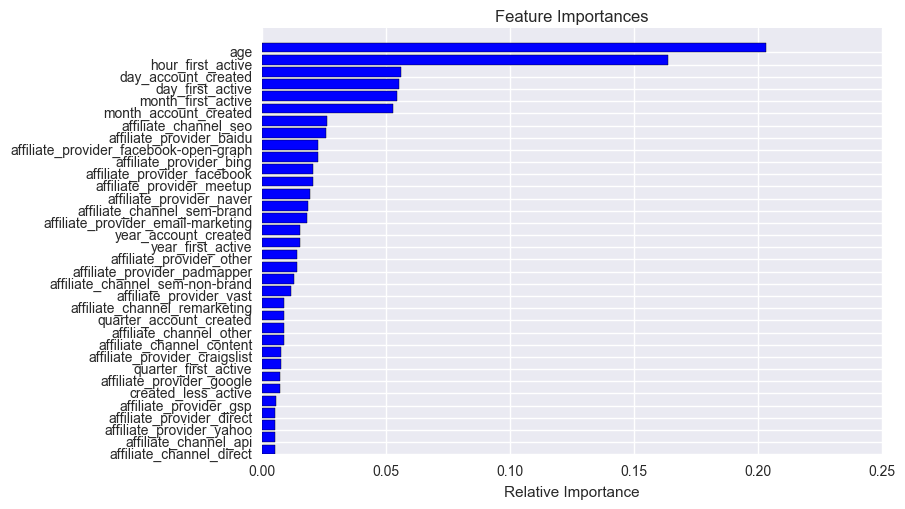

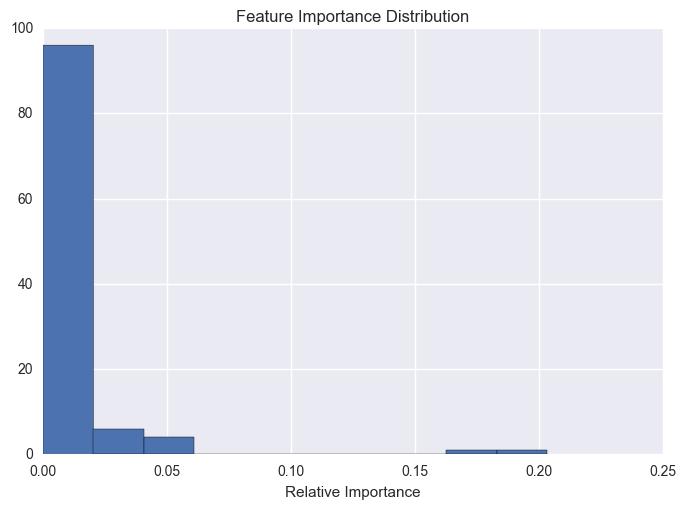

In [33]:
tree_grid_balanced = DecisionTreeClassifier(class_weight = 'balanced')
param_grid = {
                 'criterion': ['gini', 'entropy'],
                 'max_depth': [10, 20, 30],
                'min_samples_split':[2,4,6],
             }
grid_clf_balanced = GridSearchCV(tree_grid_balanced, param_grid)
labels = x_train_target['country_destination']
grid_clf_balanced.fit(x_train.values, labels)
print grid_clf_balanced.best_estimator_

get_metrics(grid_clf_balanced, x_test_target, x_test)

histogram_plot(grid_clf_balanced, x_test_target, x_test)
print 

get_importances(grid_clf_balanced.best_estimator_, x_test)

## Boosting trees Attempt 1
### Adaboost

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
[[    0     0     1     0     2     1     1     0     0   113     3]
 [    0     1     0     1     0     1     2     0     0   307    12]
 [    0     0     0     0     4     0     3     0     0   238    12]
 [    0     1     1     0     3     2     2     1     0   458    15]
 [    0     1     1     3    17     2     6     2     0  1031    42]
 [    0     1     1     1     6     0     1     0     0   490    17]
 [    2     0     2     0     3     0     0     1     0   553    20]
 [    0     0     0     0     6     0     0     1     0   151     9]
 [    0     0     1     0     0     1     0     0     0    42     0]
 [    2    29    10    28   117    46    45     4     5 13583   498]
 [    2     4     2     4    18     8    11     2     0  2032    92]]
Mean accuracy:  0.679906658061
Precision:  0.530289565601
Recall:  0.679906658061
             precision    recall  f1-score   support

         AU       0.00      0.00      0.00       121
         CA       0.03      0.00

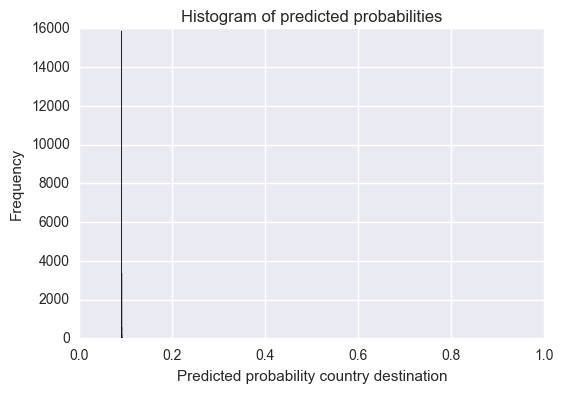


Feature importance ranking: 

age : 0.1308212693
day_account_created : 0.0691003015805
month_account_created : 0.0712455636577
quarter_account_created : 0.0301496665808
year_account_created : 0.0357139801352
hour_first_active : 0.129826297505
day_first_active : 0.0659631325379
month_first_active : 0.069067513188
quarter_first_active : 0.0371538076356
year_first_active : 0.0283645549629
created_less_active : 0.000161318525879
affiliate_channel_api : 0.000469556124473
affiliate_channel_content : 0.000644788998166
affiliate_channel_direct : 0.00569733554971
affiliate_channel_other : 0.000729822523917
affiliate_channel_remarketing : 0.000509500112461
affiliate_channel_sem-brand : 0.0128692418031
affiliate_channel_sem-non-brand : 0.00277916641554
affiliate_channel_seo : 0.00195541393901
affiliate_provider_baidu : 1.39646056579e-05
affiliate_provider_bing : 0.000563081639442
affiliate_provider_craigslist : 0.000727578651751
affiliate_provider_direct : 0.00720573545258
affiliate_provider_ema

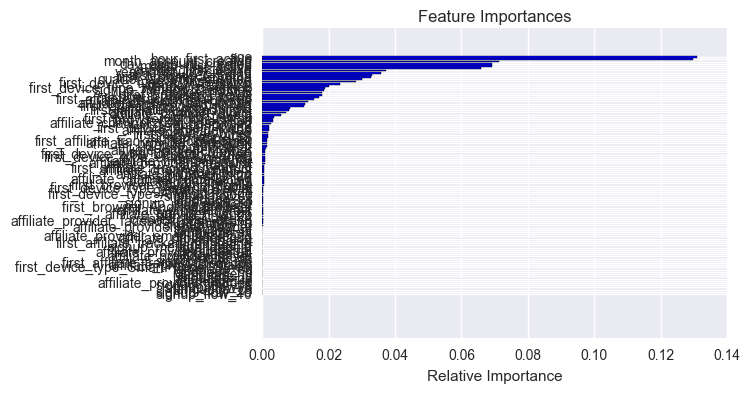

In [116]:
ada = AdaBoostClassifier(
    RandomForestClassifier(max_depth = 20, min_samples_split = 6),
    n_estimators=100,
    learning_rate=1.2,
    algorithm="SAMME")

ada.fit(x_train, x_train_target)

get_metrics(ada, x_test_target, x_test)

histogram_plot(ada, x_test_target, x_test)
print 

get_importances(ada, x_test)

## Boosting trees Attempt 2
### Adaboost

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
[[    0     0     0     0     2     1     0     0     0   126     5]
 [    0     1     0     2     2     0     2     1     0   309     5]
 [    0     0     0     1     1     1     0     0     0   245     4]
 [    0     0     1     2     1     1     1     1     0   476    11]
 [    1     1     2     3     6     4     2     1     1  1105    20]
 [    0     0     1     1     5     5     1     0     0   488     5]
 [    0     2     1     4     2     2     2     0     0   589     7]
 [    0     0     0     2     1     1     0     0     0   178     4]
 [    0     0     0     1     0     1     0     0     0    40     4]
 [    8    24    11    40    89    40    44     7     4 13761   234]
 [    1     2     3     5     7     4    11     2     0  2113    36]]
Mean accuracy:  0.68581500422
Precision:  0.520492902704
Recall:  0.68581500422
             precision    recall  f1-score   support

         AU       0.00      0.00      0.00       134
         CA       0.03      0.00  

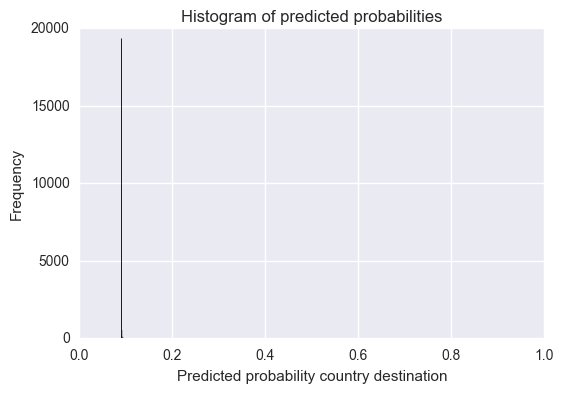


Feature importance ranking: 

first_affiliate_tracked_linked : 0.0138779148509
affiliate_provider_vast : 0.000157428495622
first_affiliate_tracked_untracked : inf
affiliate_channel_content : 0.000225712713582
affiliate_channel_sem-brand : 0.00407292319496
affiliate_provider_yahoo : 5.20500729685e-05
first_browser_Firefox : nan
first_browser_Chrome Mobile : 0.000210350387511
affiliate_provider_email-marketing : 7.84787562903e-06
first_device_type_Other/Unknown : nan
affiliate_channel_seo : 0.00132480029895
affiliate_provider_bing : 0.000234674902319
affiliate_provider_facebook : 0.000233803789649
first_browser_Chrome : 0.0305617745531
first_browser_Mobile Safari : 0.00895254815511
first_browser_Android Browser : 7.0221435384e-05
first_device_type_Android Tablet : 0.000326234763533
first_device_type_Mac Desktop : nan
first_affiliate_tracked_omg : 0.006195838427
affiliate_channel_api : 0.00093907635253
affiliate_provider_padmapper : 3.78559846187e-05
affiliate_channel_direct : 0.00571721

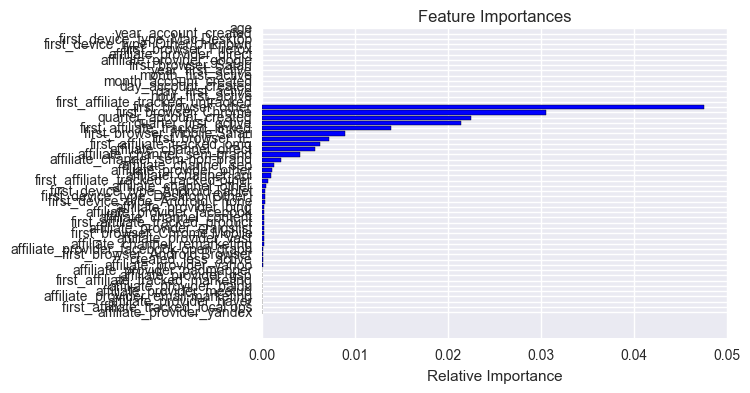

In [249]:
ada = AdaBoostClassifier(
    RandomForestClassifier(),
    n_estimators=100,
    learning_rate=0.4,
    algorithm="SAMME")

ada.fit(x_train, x_train_target)

get_metrics(ada, x_test_target, x_test)

histogram_plot(ada, x_test_target, x_test)
print 

get_importances(ada, x_test)

## Boosting trees Attempt 3
### Adaboost with balanced trees and constraints

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
[[    0     1     0     0     1     1     0     0     0   126     5]
 [    1     1     0     2     3     0     3     1     1   303     7]
 [    0     0     0     1     1     0     1     0     0   242     7]
 [    0     0     1     2     1     3     3     1     0   475     8]
 [    1     3     3     4     5     6     1     2     1  1096    24]
 [    0     1     2     3     5     8     1     0     0   478     8]
 [    0     2     2     5     3     1     4     0     0   581    11]
 [    0     0     0     2     2     1     0     0     0   176     5]
 [    0     0     0     1     0     1     0     0     0    41     3]
 [   14    33    16    56   119    57    59     9     6 13612   281]
 [    2     3     3     9    11     7    18     2     0  2085    44]]
Mean accuracy:  0.679012958642
Precision:  0.519999062109
Recall:  0.679012958642
             precision    recall  f1-score   support

         AU       0.00      0.00      0.00       134
         CA       0.02      0.00

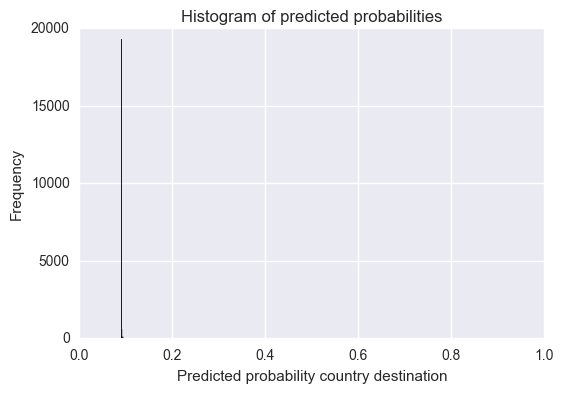


Feature importance ranking: 

first_affiliate_tracked_linked : 0.0215846422701
affiliate_provider_vast : 0.000120630979645
first_affiliate_tracked_untracked : 0.0314788599204
affiliate_channel_content : 0.00040856243096
affiliate_channel_sem-brand : 0.019619363941
affiliate_provider_yahoo : 6.8271697334e-05
first_browser_Firefox : nan
first_browser_Chrome Mobile : 0.000176567916224
affiliate_provider_email-marketing : 8.67026913381e-06
first_device_type_Other/Unknown : 0.000957714349825
affiliate_channel_seo : 0.00121493206163
affiliate_provider_bing : 0.00118334481717
affiliate_provider_facebook : 0.00048097484078
first_browser_Chrome : 0.0325361576053
first_browser_Mobile Safari : 0.00436294373568
first_browser_Android Browser : 0.00010714384764
first_device_type_Android Tablet : 0.000256558338464
first_device_type_Mac Desktop : 0.0304080825855
first_affiliate_tracked_omg : 0.0243696906579
affiliate_channel_api : 0.000949275734479
affiliate_provider_padmapper : 2.55450050949e-05
aff

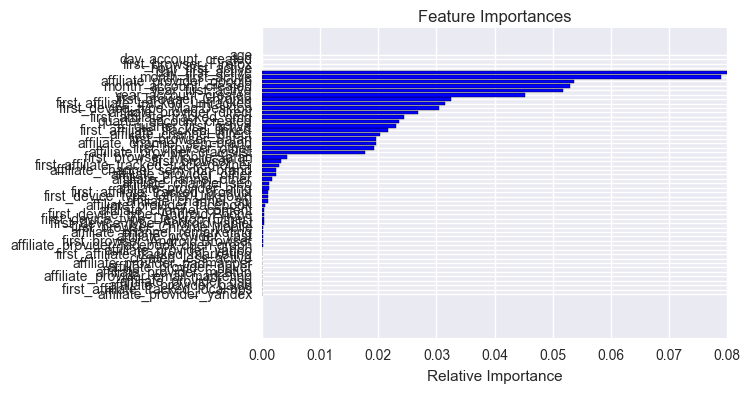

In [246]:
ada = AdaBoostClassifier(
    RandomForestClassifier(max_depth = 30, min_samples_split = 2, class_weight = 'balanced'),
    n_estimators = 100,
    learning_rate=1.2,
    algorithm="SAMME")

ada.fit(x_train, x_train_target)

get_metrics(ada, x_test_target, x_test)

histogram_plot(ada, x_test_target, x_test)
print 

get_importances(ada, x_test)

## Boosting trees Attempt 4
### Boosting with decision trees

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
[[    1     0     0     0     1     0     1     1     0   126     4]
 [    0     1     0     2     1     0     3     1     0   307     7]
 [    0     1     0     2     2     3     4     1     0   237     2]
 [    1     1     1     1     1     2     1     1     0   475    10]
 [    1     1     3     4     8     3     2     2     0  1091    31]
 [    0     1     0     1     7     4     1     0     0   484     8]
 [    0     1     1     4     4     4     2     0     0   579    14]
 [    0     0     0     1     3     1     1     0     0   174     6]
 [    0     0     0     1     0     1     0     0     0    42     2]
 [    8    25    17    48    94    52    51     6     2 13627   332]
 [    0     2     1     7     9     6    16     2     0  2095    46]]
Mean accuracy:  0.67970805819
Precision:  0.519398089922
Recall:  0.67970805819
             precision    recall  f1-score   support

         AU       0.09      0.01      0.01       134
         CA       0.03      0.00  

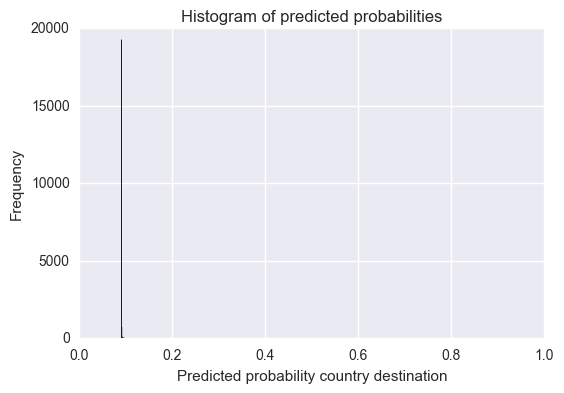


Feature importance ranking: 

first_affiliate_tracked_linked : nan
affiliate_provider_vast : 1.3360887649e-05
first_affiliate_tracked_untracked : nan
affiliate_channel_content : 7.31379730041e-05
affiliate_channel_sem-brand : 0.00131164502929
affiliate_provider_yahoo : 1.55502510267e-05
first_browser_Firefox : nan
first_browser_Chrome Mobile : 3.90161911047e-05
affiliate_provider_email-marketing : 1.98218860612e-06
first_device_type_Other/Unknown : 9.7488576569e-05
affiliate_channel_seo : 0.000182023717152
affiliate_provider_bing : 6.27472947517e-05
affiliate_provider_facebook : 5.39178200994e-05
first_browser_Chrome : nan
first_browser_Mobile Safari : nan
first_browser_Android Browser : 2.12953513372e-05
first_device_type_Android Tablet : 5.00920687193e-05
first_device_type_Mac Desktop : nan
first_affiliate_tracked_omg : inf
affiliate_channel_api : 8.6014888908e-05
affiliate_provider_padmapper : 4.01368093434e-06
affiliate_channel_direct : nan
quarter_first_active : nan
first_browser

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/tree/tree.py:475: RuntimeWarning: invalid value encountered in divide
  return self.tree_.compute_feature_importances()


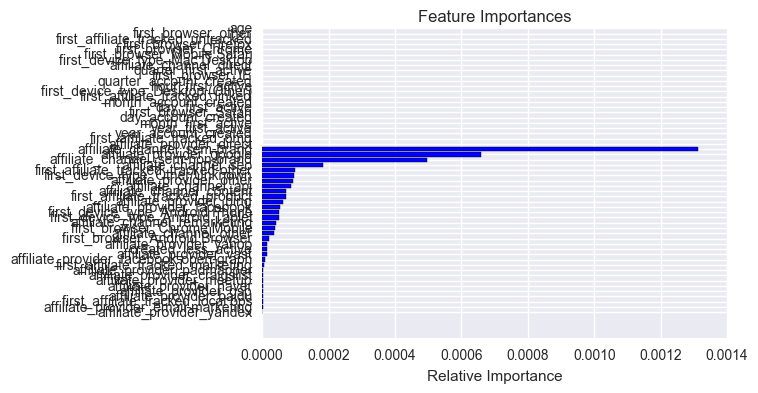

In [245]:
ada = AdaBoostClassifier(
    DecisionTreeClassifier(),
    n_estimators = 100,
    learning_rate=1.2,
    algorithm="SAMME")

ada.fit(x_train, x_train_target)

get_metrics(ada, x_test_target, x_test)

histogram_plot(ada, x_test_target, x_test)
print 

get_importances(ada, x_test)

## QDA

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
[[    2     3     1     0     0     1     0     1   113     0     0]
 [   12     8     2     0     0     1     0     4   296     1     0]
 [   18     3     0     0     1     0     0     1   234     0     0]
 [   14    12     2     1     0     0     1     5   447     1     0]
 [   50    17     8     2     1     3     0     5  1017     1     1]
 [   22     6     2     0     0     1     1     3   481     1     0]
 [   11     8     3     0     0     6     0     2   550     1     0]
 [   13     3     1     0     0     1     0     2   147     0     0]
 [    4     1     0     0     0     0     0     0    39     0     0]
 [  790   313   144     7     8    60    10   147 12843    31    14]
 [   80    51    22     0     1     7     2    24  1985     2     1]]
Mean accuracy:  0.00426989722457
Precision:  0.596780453349
Recall:  0.00426989722457
             precision    recall  f1-score   support

         AU       0.00      0.02      0.00       121
         CA       0.02      

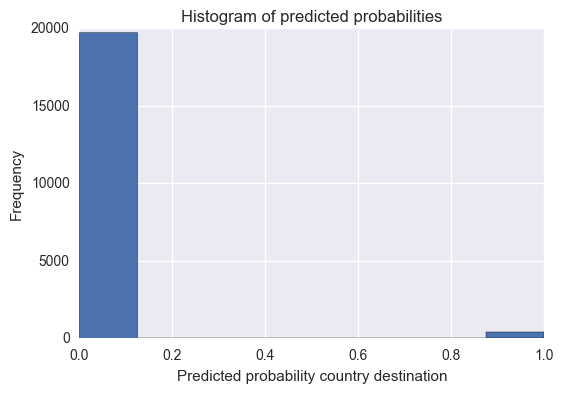

In [30]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import numpy as np

clf = QuadraticDiscriminantAnalysis()

clf.fit(x_train, x_train_target)

get_metrics(clf, x_test_target, x_test)

histogram_plot(clf, x_test_target, x_test)

## KNN

In [241]:
knn_grid = KNeighborsClassifier()
param_grid = {
                 'n_neighbors': [5,10,15],
             }
grid_clf = GridSearchCV(knn_grid, param_grid)
labels = x_train_target['country_destination']
grid_clf.fit(x_train.values, labels)
print grid_clf.best_estimator_

get_metrics(grid_clf, x_test_target, x_test)

histogram_plot(grid_clf.best_estimator_, x_test_target, x_test)
print 


KeyboardInterrupt: 

## XGBoost Attempt 1


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=10, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
[[    0     0     0     0     0     0     0     0     0   119     0]
 [    0     0     0     0     0     0     0     0     0   324     0]
 [    0     0     0     0     0     0     0     0     0   259     0]
 [    0     0     0     0     0     0     0     0     0   488     0]
 [    0     0     0     0     0     0     0     0     0  1100     0]
 [    0     0     0     0     0     0     0     0     0   517     0]
 [    0     0     0     0     0     0     0     0     0   612     0]
 [    0     0     0     0     0     0     0     0     0   186     0]
 [    0     0     0     0     0     0     0     0     0    54     0]
 [    0     0     0     0     0     0     0     0

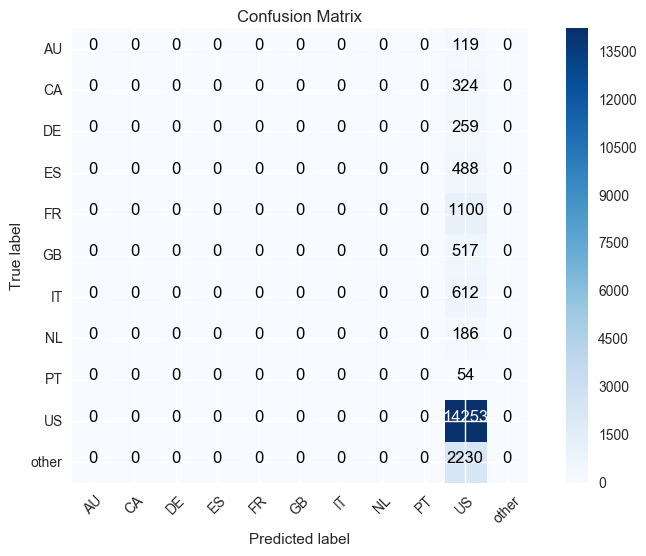

Mean accuracy:  0.707625856419
Precision:  0.500734352673
Recall:  0.707625856419


/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

         AU       0.00      0.00      0.00       119
         CA       0.00      0.00      0.00       324
         DE       0.00      0.00      0.00       259
         ES       0.00      0.00      0.00       488
         FR       0.00      0.00      0.00      1100
         GB       0.00      0.00      0.00       517
         IT       0.00      0.00      0.00       612
         NL       0.00      0.00      0.00       186
         PT       0.00      0.00      0.00        54
         US       0.71      1.00      0.83     14253
      other       0.00      0.00      0.00      2230

avg / total       0.50      0.71      0.59     20142

Test - Histogram of predicted probabilities:


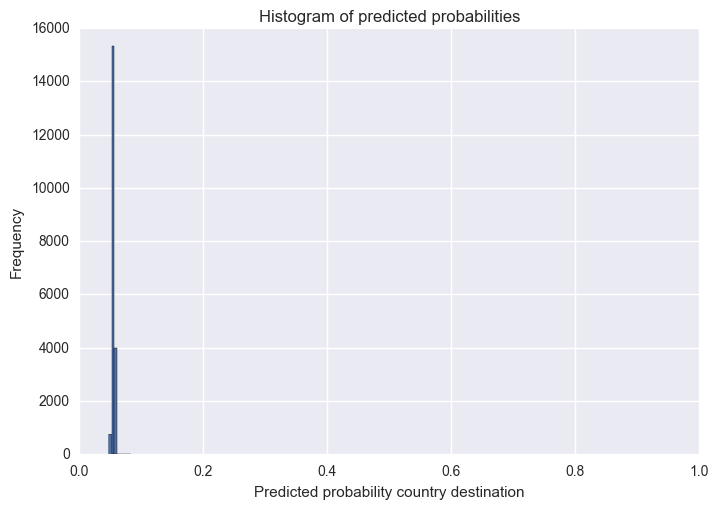


Feature importance ranking: 

original size (108,)
size after reducing features (34,)
max feature importance 0.218796
min feature importance 0.0


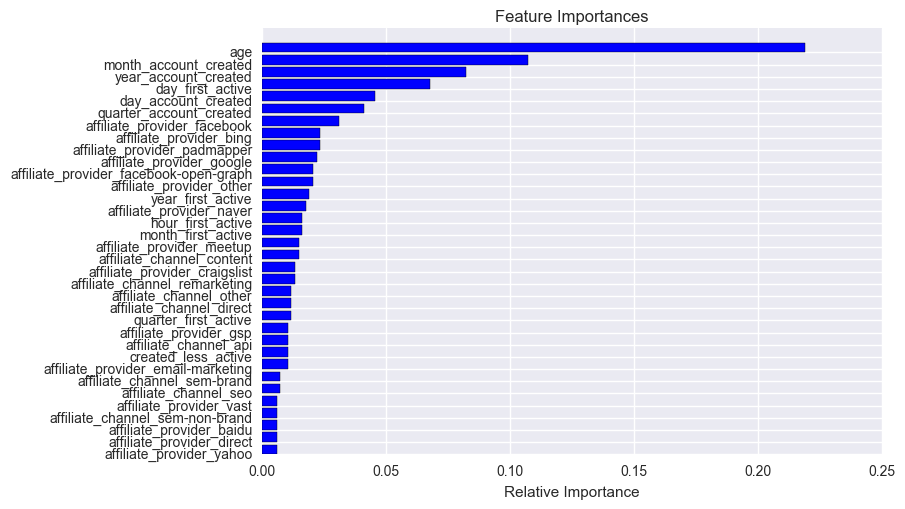

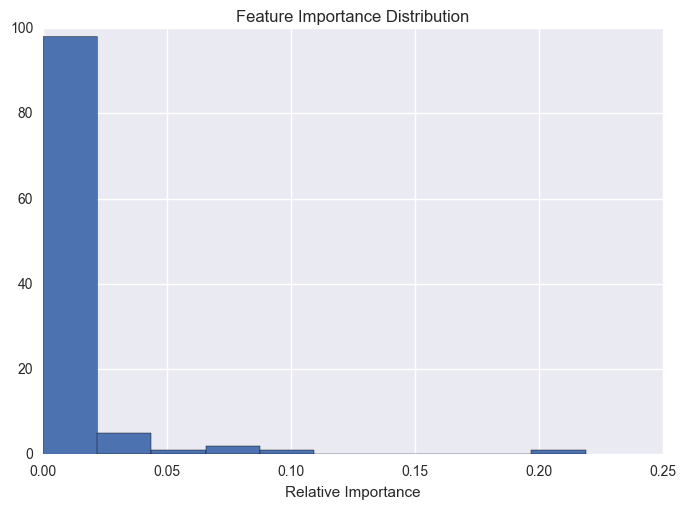

In [36]:
import xgboost

model = xgboost.XGBClassifier(n_estimators = 10)
model.fit(x_train, x_train_target)

print model

get_metrics(model, x_test_target, x_test)

histogram_plot(model, x_test_target, x_test)
print 

get_importances(model, x_test)

## Gradient Boosting Attempt 1

In [33]:
# model = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100, learning_rate=1.1))
model = GradientBoostingClassifier(n_estimators=10, learning_rate=.9)

model.fit(x_train, x_train_target)
print model

get_metrics(model, x_test_target, x_test)

histogram_plot(model, x_test_target, x_test)
print 

get_importances(model, x_test)


KeyboardInterrupt: 